# Tracking a moving stystem
## Outlier mean

We consider a state-space model of the form
$$
\begin{aligned}
    p(z_t \vert z_{t-1}) &= {\cal N}(z_t \vert F z_{t-1}, Q_t)\\
    p(y_t \vert z_t) &= \text{St}(y_t \vert  H_t z_t, R_t, \nu)
\end{aligned}
$$

In [211]:
import jax
import datagen
import pandas as pd
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import time
from functools import partial
from rebayes_mini import callbacks
from bayes_opt import BayesianOptimization
from rebayes_mini.methods import student_t_filter as stf
from rebayes_mini.methods import gauss_filter as kf
from rebayes_mini.methods import robust_filter as rkf
from rebayes_mini.methods import generalised_bayes_filter as gbf

In [212]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "KF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "KF": "lightseagreen",
    "WLF-MD": "gold",
    "KF-B": "darkorange",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Multiple samples

In [213]:
delta = 0.1
dynamics_covariance = 0.1
obs_covariance = 10.0

In [214]:
name_dgen = "covariance"

match name_dgen:
    case "covariance":
        dgen = datagen.GaussStMovingObject2D(
            delta, dynamics_covariance, obs_covariance,
            dof_observed=2.05
        )
    case "mean":
        dgen = datagen.GaussMeanOutlierMovingObject2D(
            delta, dynamics_covariance, obs_covariance,
            outlier_proba=0.05,
            outlier_scale=2.0,
        )
    case "added_mean":
        dgen = datagen.GaussOneSideOutlierMovingObject2D(
            delta, dynamics_covariance, obs_covariance,
            outlier_proba=0.05,
            outlier_minval=-100,
            outlier_maxval=100
        )
    case _:
        raise ValueError(f"Dgen {name_dgen} not valid")

In [215]:
key = jax.random.PRNGKey(314)
initial_mean = initial_mean = jnp.array([0.0, 0.0, 1.0, 1.0])

n_steps = 1000
n_samples = 500
keys = jax.random.split(key, n_samples)

colors = plt.cm.viridis(jnp.linspace(0, 1, n_samples))
datasets = jax.vmap(dgen.sample, in_axes=(0, None, None))(keys, initial_mean, n_steps)

yv = datasets["observed"]
statev = datasets["latent"]

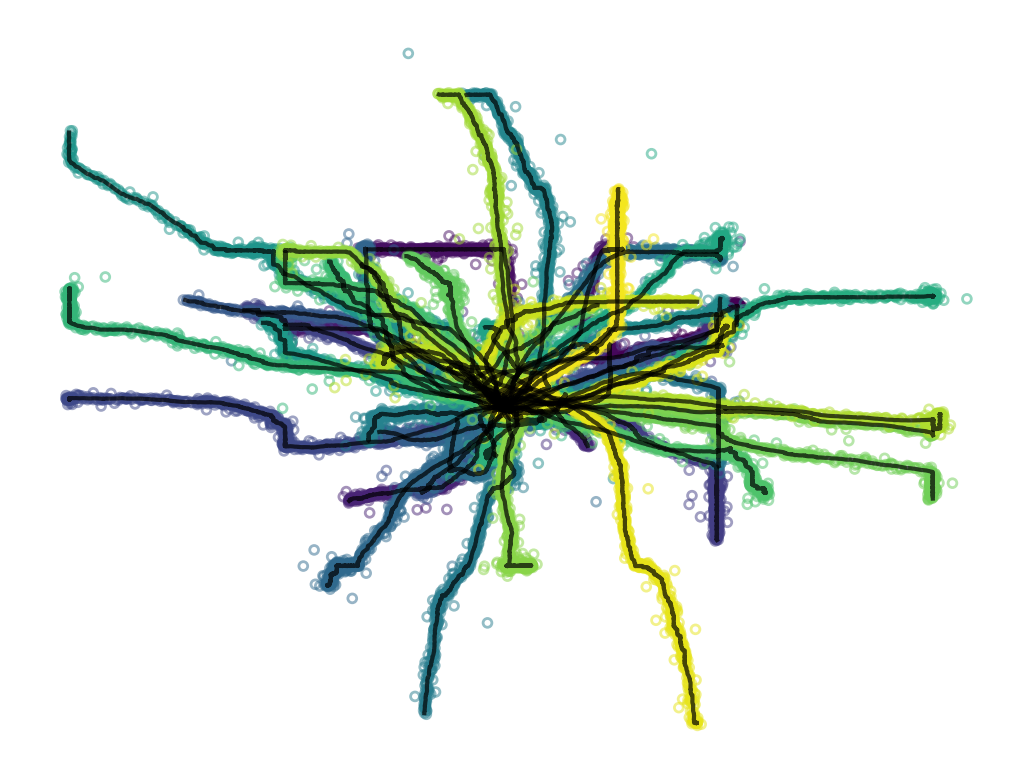

In [216]:
datasets_cpu = jax.tree_map(lambda x: np.array(x[::10]), datasets)
for i, color in enumerate(colors[::10]):
    dataset = jax.tree_map(lambda x: x[i], datasets_cpu)
    plt.plot(*dataset["latent"][:, :2].T, c="black", alpha=0.7)
    plt.scatter(*dataset["observed"].T, edgecolor=color, color="none", s=10, alpha=0.5)
    
plt.axis("off");

In [217]:
def latent_fn(z):
    return dgen.transition_matrix @ z

def measurement_fn(z, _):
    return dgen.projection_matrix @ z

## Metrics

In [218]:
time_methods = {}
hist_methods = {}
err_methods = {}
configs = {}

## Kalman Filter

In [219]:
@jax.jit
def filter_kf(measurements, state):
    nsteps = len(measurements)
    agent_imq = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=1e8,
    )
    
    init_bel = agent_imq.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent_imq.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, jnp.ones(n_steps))

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist

In [220]:
method = "KF"

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_kf(y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
err_methods[method] = hist_bel - statev
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.61it/s]


## KF-IW

In [221]:
@jax.jit
def filter_kfiw(noise_scaling, n_inner, measurements, state):
    n_inner = n_inner.astype(int)
    agent_rkf = rkf.KalmanFilterInverseWishart(
        dgen.transition_matrix,
        dgen.dynamics_covariance,
        dgen.observation_covariance,
        n_inner=n_inner,
        noise_scaling=noise_scaling
    )
    
    
    init_bel = agent_rkf.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent_rkf.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, dgen.projection_matrix)
    
    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_kfiw(noise_scaling, n_inner):
    err, _ = filter_kfiw(noise_scaling, n_inner, yv[0], statev[0])
    return -err.max()

In [222]:
bo = BayesianOptimization(
    bo_filter_kfiw,
    pbounds={
        "noise_scaling": (1e-6, 20),
        "n_inner":  (1, 10),
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  n_inner  | noise_... |
-------------------------------------------------
| 4         | -166.3    | 7.552     | 5.21      |
| 6         | -166.3    | 7.897     | 5.231     |
| 15        | -163.3    | 1.952     | 1.208     |


In [223]:
method = "KF-IW"
noise_scaling = bo.max["params"]["noise_scaling"]
n_inner = bo.max["params"]["n_inner"]

configs[method] = bo.max["params"]

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_kfiw(noise_scaling, n_inner, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
err_methods[method] = hist_bel - statev
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 44.73it/s]


## WLF-IMQ

In [224]:
@jax.jit
def filter_wlfimq(soft_threshold, measurements, state):
    nsteps = len(measurements)
    agent = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=soft_threshold,
    )
    
    init_bel = agent.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, jnp.ones(n_steps))

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_wlfimq(soft_threshold):
    err, _ = filter_wlfimq(soft_threshold, yv[0], statev[0])
    return -err.max()

In [225]:
bo = BayesianOptimization(
    bo_filter_wlfimq,
    pbounds={
        "soft_threshold": (1e-6, 20)
    },
    random_state=314,
    verbose=1,
    allow_duplicate_points=True
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   | soft_t... |
-------------------------------------
| 2         | -166.1    | 11.77     |
| 3         | -164.5    | 5.301     |
| 8         | -164.1    | 5.21      |
| 10        | -164.1    | 5.215     |
| 29        | -163.1    | 4.327     |
| 39        | -162.6    | 3.991     |


In [226]:
method = "WLF-IMQ"
soft_threshold = bo.max["params"]["soft_threshold"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_wlfimq(soft_threshold, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
err_methods[method] = hist_bel - statev
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.69it/s]


## WLF-MD

In [227]:
@jax.jit
def filter_wlfmd(threshold, measurements, state):
    agent = rkf.ExtendedKalmanFilterMD(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        threshold=threshold
    )
    
    init_bel = agent.init_bel(initial_mean, cov=1.0)
    
    _, hist = agent.scan(
        init_bel, measurements, jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean
    )

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_wlfmd(threshold):
    err, _ = filter_wlfmd(threshold, yv[0], statev[0])
    return -err.max()

In [228]:
bo = BayesianOptimization(
    bo_filter_wlfmd,
    pbounds={
        "threshold": (1e-6, 20)
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   | threshold |
-------------------------------------
| 2         | -167.6    | 11.77     |
| 8         | -167.5    | 5.21      |
| 14        | -167.1    | 7.72      |
| 16        | -166.9    | 5.564     |
| 23        | -166.9    | 3.655     |
| 29        | -166.9    | 4.307     |
| 31        | -166.5    | 6.252     |


In [229]:
method = "WLF-MD"
threshold = bo.max["params"]["threshold"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_wlfmd(threshold, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
err_methods[method] = hist_bel - statev
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.85it/s]


## KF-B

In [230]:
@jax.jit
def filter_kfb(alpha, beta, n_inner, measurements, state):
    """
    Outlier ekf
    """
    n_inner = n_inner.astype(int)
    agent = rkf.ExtendedKalmanFilterBernoulli(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        alpha=alpha,
        beta=beta,
        tol_inlier=1e-7,
        n_inner=n_inner,
    )

    init_bel = agent.init_bel(initial_mean, cov=1.0)
    
    _, hist = agent.scan(
        init_bel, measurements, jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean
    )

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_kfb(alpha, beta, n_inner):
    err, _ = filter_kfb(alpha, beta, n_inner, yv[0], statev[0])
    err = -err.max()
    err = jax.lax.cond(jnp.isnan(err), lambda: -1e6, lambda: err)
    return err

In [231]:
bo = BayesianOptimization(
    bo_filter_kfb,
    pbounds={
        "alpha": (0.0, 5.0),
        "beta": (0.0, 5.0),
        "n_inner": (1, 10),
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |   alpha   |   beta    |  n_inner  |
-------------------------------------------------------------
| 10        | -169.4    | 4.174     | 0.5288    | 1.544     |


In [232]:
method = "KF-B"
alpha = bo.max["params"]["alpha"]
beta = bo.max["params"]["beta"]
n_inner = bo.max["params"]["n_inner"].astype(int)
configs[method] = bo.max["params"]

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_kfb(alpha, beta, n_inner, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
err_methods[method] = hist_bel - statev
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.53it/s]


## Store data

## Plot comparison

In [233]:
diff_df = jax.tree_map(lambda x: np.sum(x ** 2, axis=1), err_methods)

diff_df = pd.concat([
    pd.DataFrame(diff_df[k]).reset_index().melt("index").assign(method=k)
    for k in diff_df
])
diff_df = diff_df.rename(
    {
        "variable": "state",
        "value": "error",
        "index": "trial"
    },
    axis=1
)

# diff_df["state"] = diff_df["state"].apply(lambda x: rf"$\theta_{x}$")

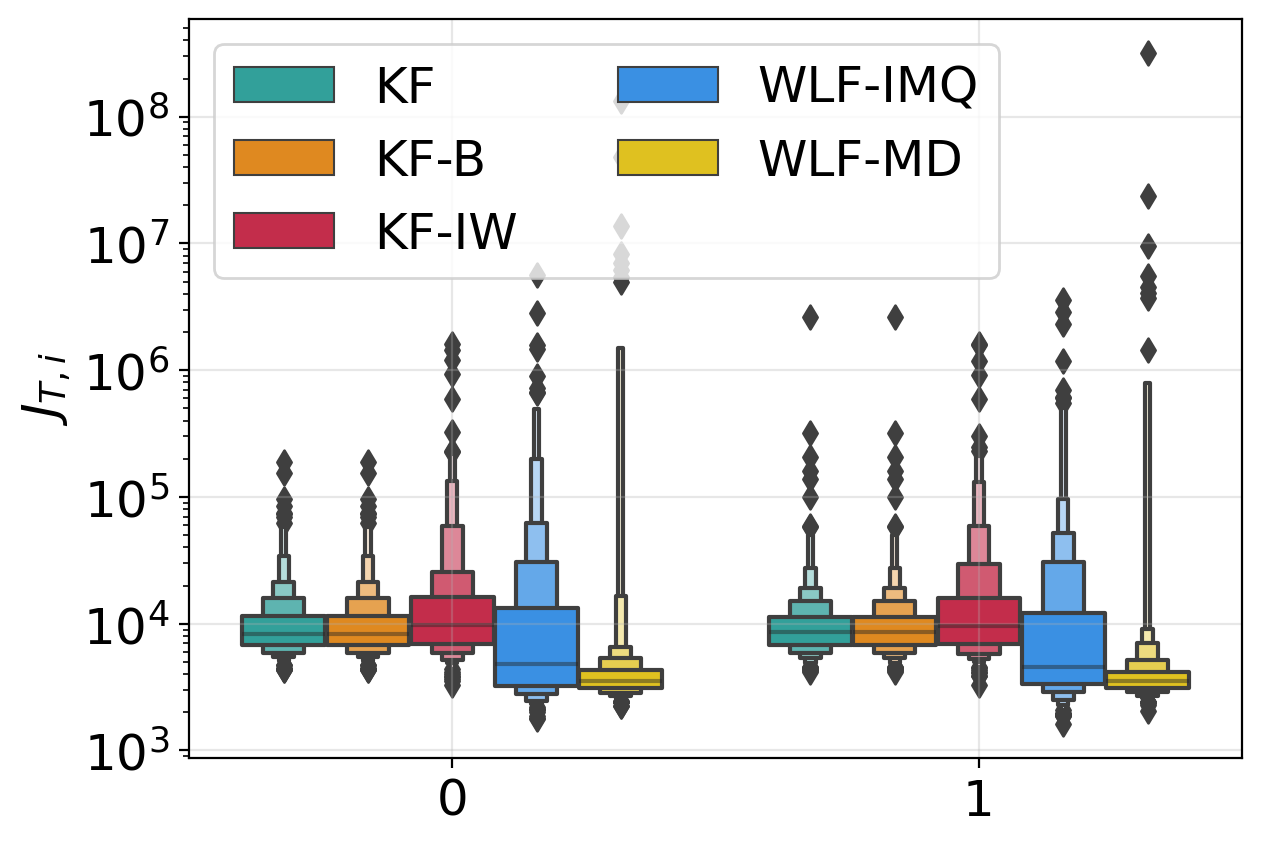

In [234]:
methods = sorted(diff_df.method.unique())
sns.boxenplot(
    y="error",
    x="state",
    hue="method",
    data=diff_df.query("state <= 1"),
    palette=cmap,
    hue_order=methods,
)
plt.legend(ncol=2)
plt.xlabel("")
plt.ylabel("$J_{T,i}$")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.yscale("log")
# plt.savefig(f"./figures/2d-ssm-comparison-outlier-{name_dgen}.png", dpi=300)

In [235]:
# remove first iteration (used to compile functions)
time_df = pd.DataFrame(time_methods).iloc[1:]

In [236]:
(time_df.mean(axis=0) / time_df["KF"].mean(axis=0) - 1)

KF         0.000000
KF-IW      0.199746
WLF-IMQ   -0.000133
WLF-MD     0.054354
KF-B       1.010122
dtype: float64

In [237]:
summary = pd.merge(
    diff_df,
    time_df.reset_index().melt("index").rename({"index": "trial", "variable": "method"}, axis=1),
    on=["method", "trial"],
    how="inner"
)
summary.head()

,trial,state,error,method,value
0,1,0,9649.352539,KF,0.000259
1,1,1,8516.492188,KF,0.000259
2,1,2,7959.137207,KF,0.000259
3,1,3,3296.015381,KF,0.000259
4,2,0,6863.392090,KF,0.000059


In [238]:
summary.shape

(9980, 5)

In [239]:
time_df.reset_index().melt("index").shape

(2495, 3)

In [240]:
(time_df / time_df["KF"].mean() - 1).describe().loc["mean"].round(3).sort_index()

KF        -0.000
KF-B       1.010
KF-IW      0.200
WLF-IMQ   -0.000
WLF-MD     0.054
Name: mean, dtype: float64

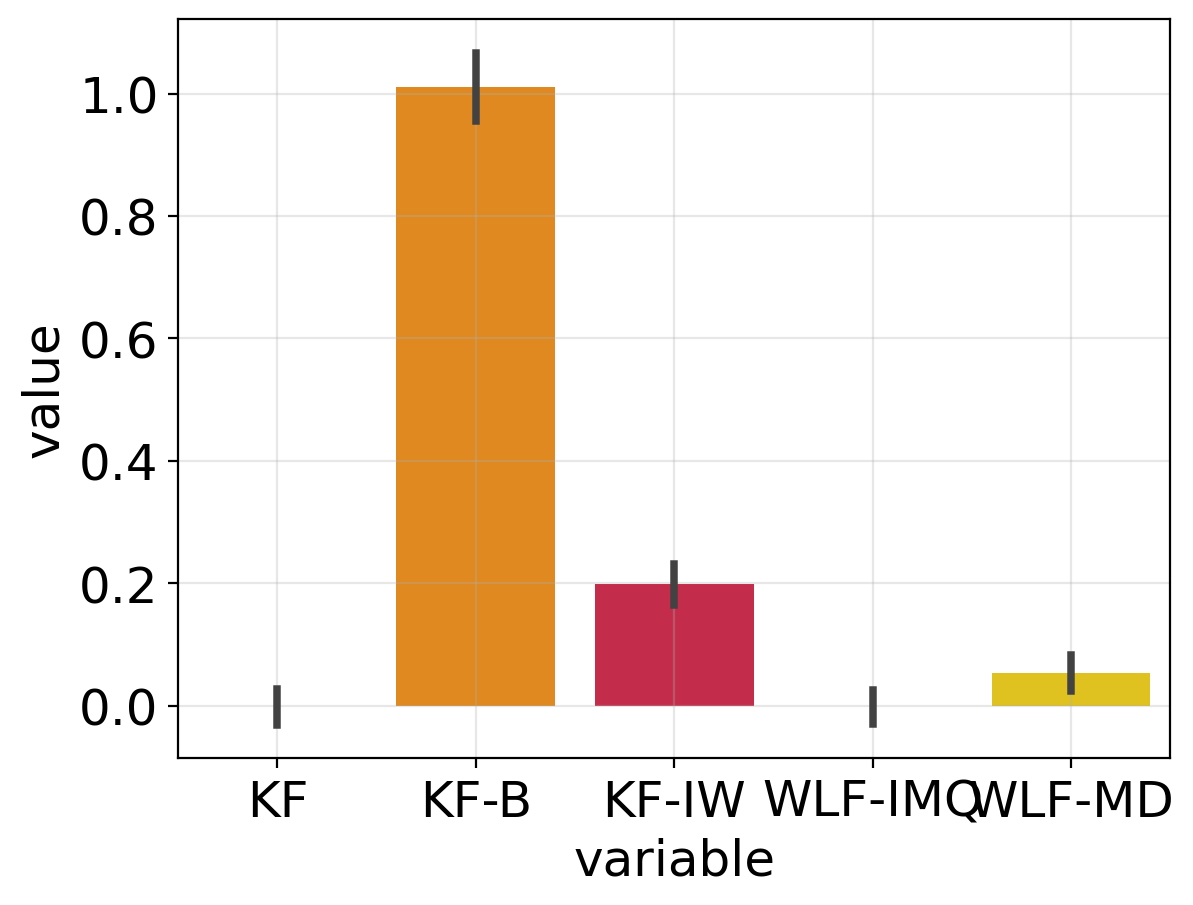

In [241]:
sns.barplot(
    x="variable",
    y="value",
    data=(time_df / time_df["KF"].mean() - 1).melt(),
    order=methods,
    palette=cmap
)
plt.grid(alpha=0.3)

## Single model comparison

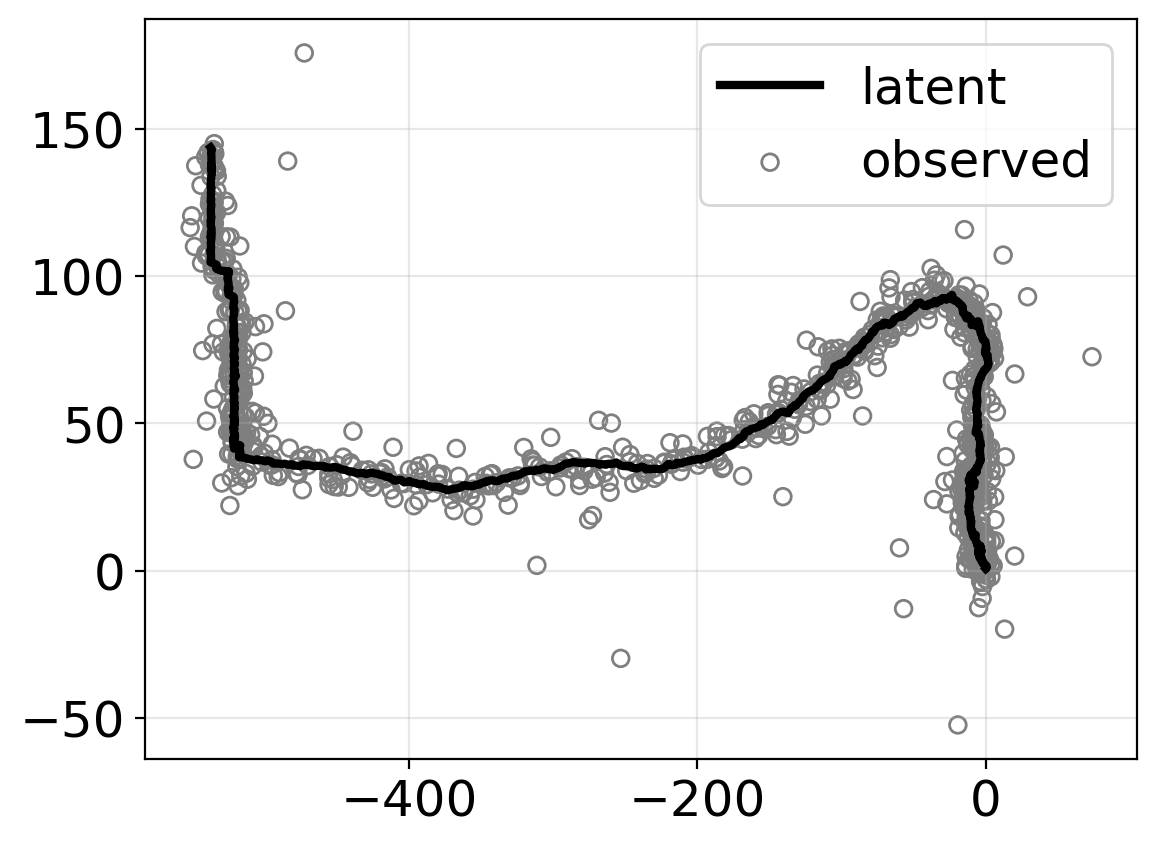

In [245]:
i = 11
# i = 2
latent_i = datasets["latent"][i, :, :2].T
observed_i = yv[i]

plt.plot(*latent_i, c="black", label="latent", linewidth=3)
plt.scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed")
plt.legend()
plt.grid(alpha=0.3)

In [246]:
hist_runs = jax.tree_map(lambda x: x[i, :, :2], hist_methods)

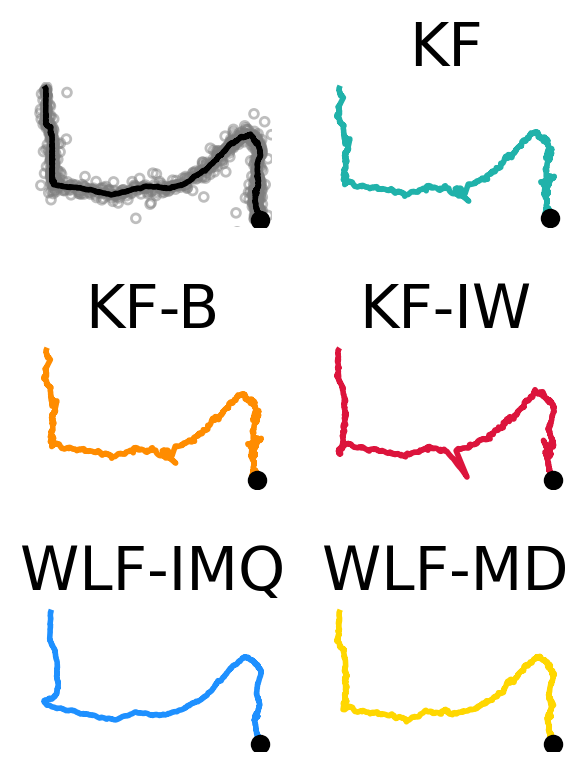

In [247]:
fig, axs = plt.subplots(3, 2, figsize=(6.4 * 0.5, 4.2))

for ax, key in zip(axs.ravel()[1:], hist_runs):
    state_est = hist_runs[key]
    ax.plot(*state_est.T, c=cmap[key], linewidth=2)
    ax.set_title(key)
    ax.axis("off")
    ax.scatter(0,0, c="black", zorder=3)
    
ylim = ax.get_ylim()
xlim = ax.get_xlim()

axs[0, 0].scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed", alpha=0.5, s=10)
axs[0, 0].plot(*latent_i, c="black", label="latent", linewidth=2.0)
axs[0, 0].axis("off")
axs[0, 0].scatter(0, 0, c="black", zorder=3)
axs[0, 0].set_ylim(*ylim)
axs[0, 0].set_xlim(*xlim)


plt.tight_layout()
plt.savefig(f"./figures/2d-ssm-comparison-single-run-{name_dgen}.png", dpi=300)